In [1]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Conv1D,Conv2D,Flatten,BatchNormalization,MaxPooling1D,Dropout,Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,MaxPooling2D,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import Activation,Add,Reshape,Permute,LeakyReLU,UpSampling2D,Conv2DTranspose,Concatenate
from tensorflow.keras.layers import Lambda,InputSpec,Layer,Input,Add,ZeroPadding2D,UpSampling2D,MaxPooling2D,Conv2D,Bidirectional,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam,SGD
import datetime
from tensorflow.keras.utils import plot_model
import os
# import flask
import json

time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
# def load_dataset():
name_file = 'final_4p5M.pkl'
ddata = pd.read_pickle(f'./final_2M/{name_file}')
ddata['Label'].value_counts()

Benign             1500000
DDOS               1000000
Port_scan          1000000
Password_attack    1000000
Name: Label, dtype: int64

In [2]:
# ddata.info()
ddata.drop(['Timestamp'],axis=1,inplace=True)

# DATA

In [3]:
df = ddata
# df.drop(['fwd_header_length'], axis=1, inplace=True)

In [4]:
# drop columns
# df.drop(['protocol'], axis=1, inplace=True)
# df.drop(['Dst Port'], axis=1, inplace=True)

In [5]:
df.describe(include=[int, float])
df.describe(include=[object]).transpose()

,count,unique,top,freq
Label,4500000,4,Benign,1500000


# Dealing with duplicates

In [6]:
df.duplicated().any()

True

In [7]:
# print('Data size BEFORE deleteting instances with duplicate values: ', df.shape[0], end='\n\n')

# # Remove duplicate rows
# df.drop_duplicates(inplace=True, keep=False, ignore_index=True)

# print('Data size AFTER deleteting instances containing duplicate values: ', df.shape[0])

Dealing with missing values

In [8]:
df.isnull().sum().sum()
df.isnull().sum() / df.shape[0]

Dst Port         0.0
Protocol         0.0
Flow Duration    0.0
Tot Fwd Pkts     0.0
Tot Bwd Pkts     0.0
                ... 
Idle Mean        0.0
Idle Std         0.0
Idle Max         0.0
Idle Min         0.0
Label            0.0
Length: 79, dtype: float64

In [9]:
df.columns[df.isnull().any()]

Index(['Flow Byts/s'], dtype='object')

In [10]:
print('Data size BEFORE deleteting instances with missing values: ', df.shape[0], end='\n\n')

# Remove missing values
df.dropna(axis=0, inplace=True, how="any")

print('Data size AFTER deleteting instances containing missing values: ', df.shape[0])

Data size BEFORE deleteting instances with missing values:  4500000

Data size AFTER deleteting instances containing missing values:  4482764


# Dealing with infinite values

In [11]:
# Checking if all values are finite.
np.all(np.isfinite(df.drop(['Label'], axis=1)))

False

In [12]:
# Replace infinite values to NaN
df.replace([-np.inf, np.inf], np.nan, inplace=True)

# Check which labels are related to infinte values
df[(df['Flow Byts/s'].isnull()) & (df['Flow Pkts/s'].isnull())].Label.unique()


array(['DDOS', 'Benign', 'Password_attack'], dtype=object)

In [13]:
print('Data size BEFORE deleteting instances with infinite values: ', df.shape[0], end='\n\n')

# Remove infinte values
df.dropna(axis=0, how='any', inplace=True)

print('Data size AFTER deleteting instances containing infinite values: ', df.shape[0])

Data size BEFORE deleteting instances with infinite values:  4482764

Data size AFTER deleteting instances containing infinite values:  4477942


# Dealing with features with quasi null std deviation

In [14]:
dataset_std = df.std(numeric_only=True)
dataset_std

Dst Port         2.047368e+04
Protocol         3.492356e+00
Flow Duration    6.100544e+08
Tot Fwd Pkts     2.673366e+01
Tot Bwd Pkts     6.835018e+01
                     ...     
Active Min       5.700026e+05
Idle Mean        7.898618e+14
Idle Std         6.293050e+13
Idle Max         7.902661e+14
Idle Min         7.919610e+14
Length: 78, dtype: float64

In [15]:
# Find Features that meet the threshold
constant_features = [column for column, std in dataset_std.iteritems() if std < 0.01]

# Drop the constant features
df.drop(labels=constant_features, axis=1, inplace=True)
print(constant_features)

['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg']


C:\Users\fancyma\AppData\Local\Temp\ipykernel_52604\1058764042.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  constant_features = [column for column, std in dataset_std.iteritems() if std < 0.01]


# Observing the outliers

In [16]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers with interquartile range
filt = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
print(filt.sum())

C:\Users\fancyma\AppData\Local\Temp\ipykernel_52604\4034545612.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
C:\Users\fancyma\AppData\Local\Temp\ipykernel_52604\4034545612.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
C:\Users\fancyma\AppData\Local\Temp\ipykernel_52604\4034545612.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  filt = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))


ACK Flag Cnt        719645
Active Max          186585
Active Mean         186585
Active Min          186585
Active Std          131862
                    ...   
Tot Bwd Pkts        400103
Tot Fwd Pkts        440526
TotLen Bwd Pkts    1053901
TotLen Fwd Pkts     658446
URG Flag Cnt         76039
Length: 72, dtype: int64


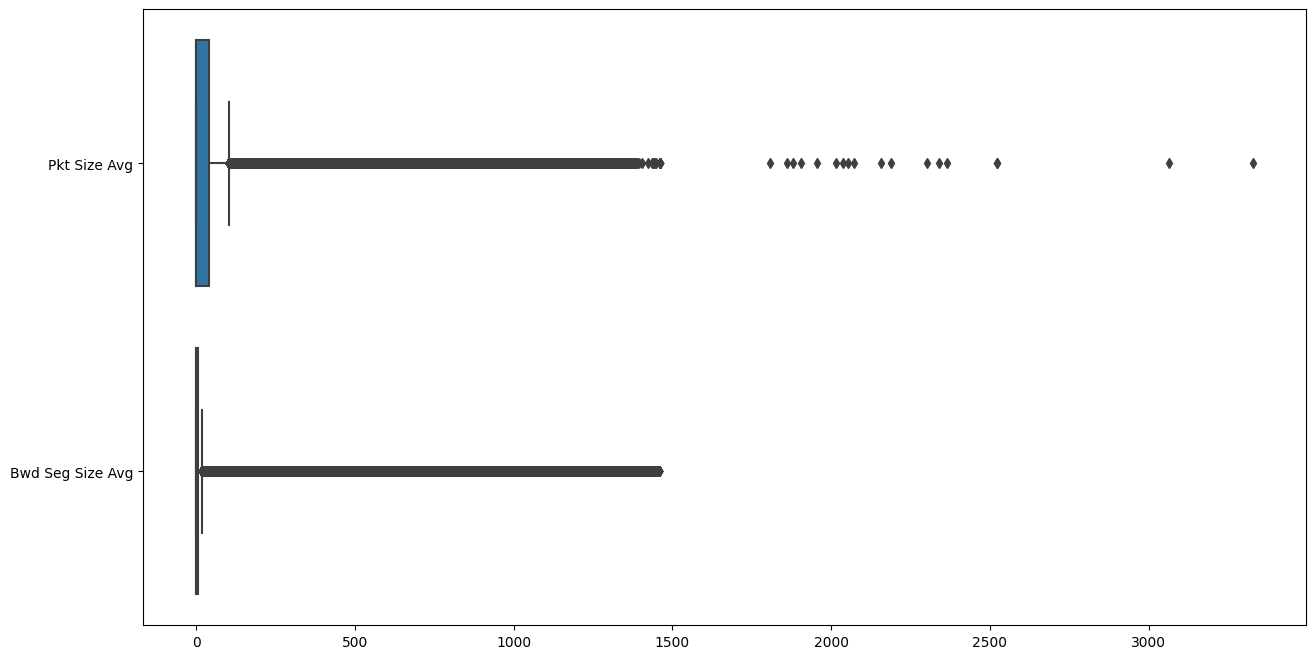

In [17]:
fig = plt.figure(figsize=(15, 8))
sns.boxplot(data=df[['Pkt Size Avg', 'Bwd Seg Size Avg']], orient="h")

#plt.title('Summary of some variables containing outliers', fontsize=18)
plt.show()
fig.savefig(os.path.join('./images', f'outliers_{time}.pdf'))

Convert the dtype of some features

In [18]:
df[['Flow Byts/s', 'Flow Pkts/s']] = df[['Flow Byts/s', 'Flow Pkts/s']].apply(pd.to_numeric)

# Data Exploration

### Correlation Matrix

In [19]:
dataset_corr = df.corr()
dataset_corr.head(5)

C:\Users\fancyma\AppData\Local\Temp\ipykernel_52604\306764757.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_corr = df.corr()


,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Dst Port,1.000000,-0.232549,-0.004508,-0.046559,-0.029843,-0.006695,-0.014645,-0.201159,-0.192798,-0.239464,...,-0.168489,0.262313,-0.036065,-0.046529,-0.051291,-0.028511,0.240812,-0.006114,0.240318,0.240509
Protocol,-0.232549,1.000000,-0.002117,-0.026773,-0.013645,-0.002635,-0.006843,-0.046484,0.841680,0.199520,...,-0.071594,-0.640331,-0.023964,-0.026710,-0.031595,-0.019569,-0.476621,-0.018073,-0.477422,-0.474350
Flow Duration,-0.004508,-0.002117,1.000000,-0.000505,0.003699,0.000479,0.002740,0.011160,-0.001710,0.007315,...,0.015675,-0.005619,0.005240,0.010442,0.009335,0.003483,-0.009185,0.001441,-0.009096,-0.009241
Tot Fwd Pkts,-0.046559,-0.026773,-0.000505,1.000000,0.851479,0.091283,0.842074,0.159057,-0.023161,0.104328,...,0.288311,-0.049760,0.093526,0.106330,0.127640,0.074912,-0.066956,0.018486,-0.065845,-0.067807
Tot Bwd Pkts,-0.029843,-0.013645,0.003699,0.851479,1.000000,0.088838,0.994836,0.108437,-0.012806,0.064771,...,0.236228,-0.025107,0.088128,0.104451,0.122355,0.068774,-0.037742,0.009656,-0.037160,-0.038179


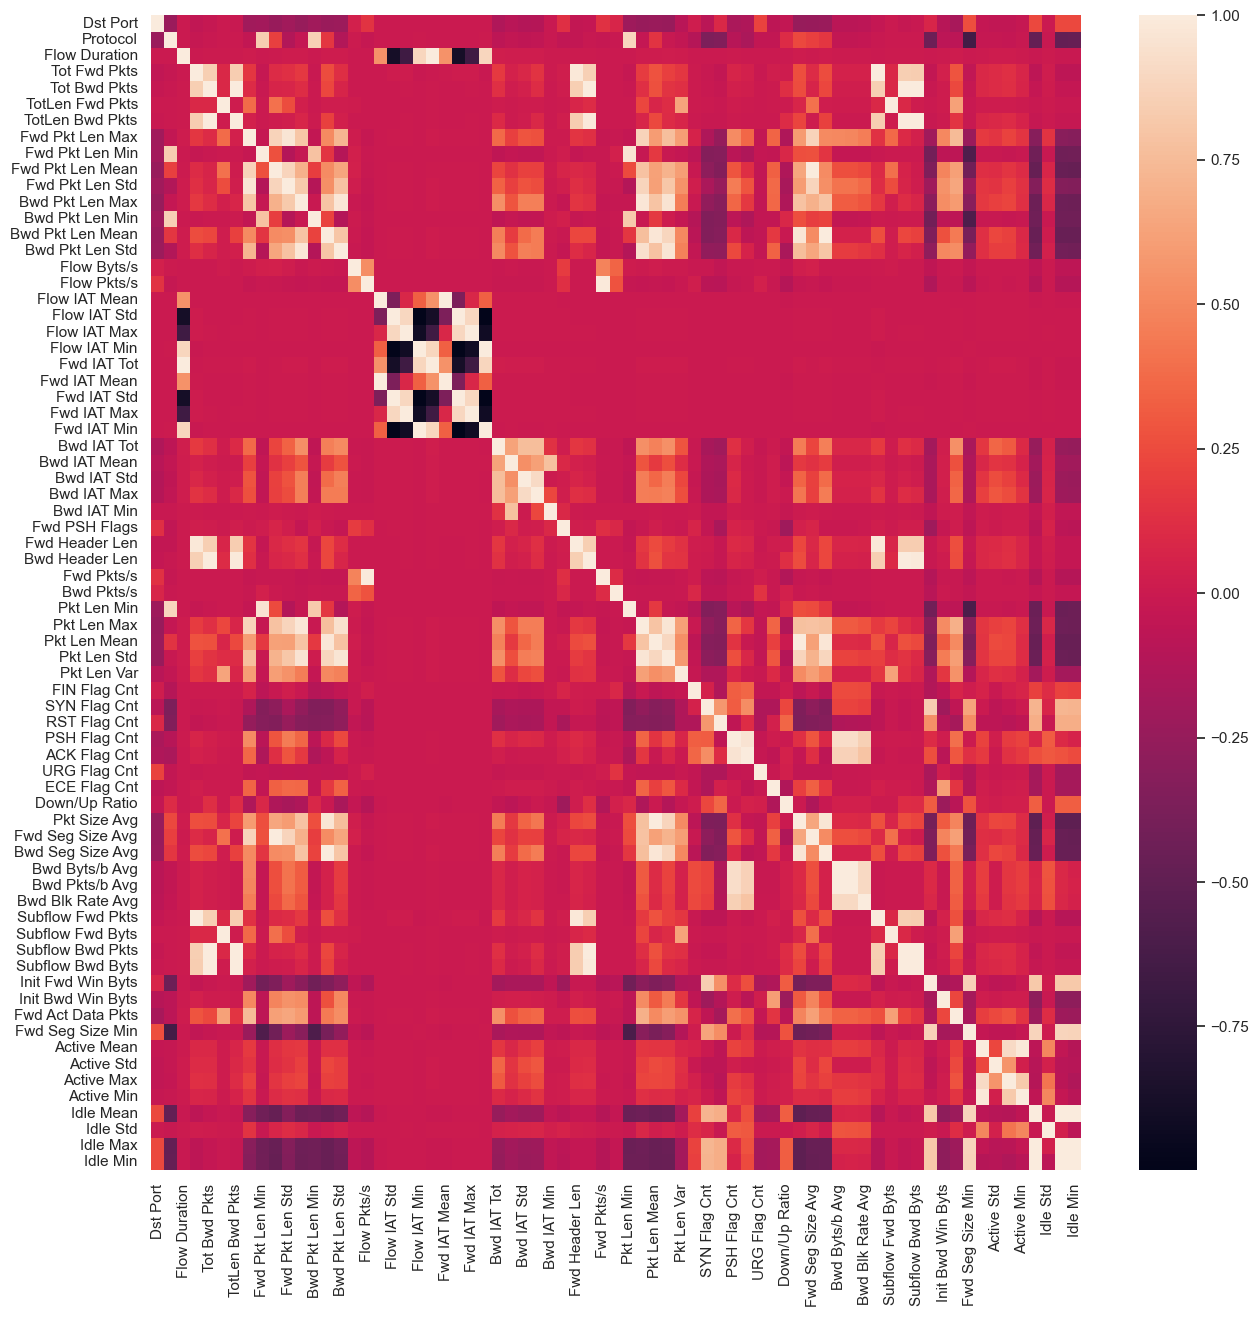

In [20]:
fig = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.0)
ax = sns.heatmap(dataset_corr, annot=False)
fig.savefig(os.path.join('./images', f'correlation matrix_{time}.pdf'))

In [21]:
# Create & Apply mask
mask = np.triu(np.ones_like(dataset_corr, dtype=bool))
tri_df = dataset_corr.mask(mask)

# Find Features that meet the threshold
correlated_features = [c for c in tri_df.columns if any(tri_df[c] > 0.98)]
print(correlated_features)
# Drop the highly correlated features
df.drop(labels=correlated_features, axis=1, inplace=True)

['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Bwd Header Len', 'Pkt Len Mean', 'Bwd Byts/b Avg', 'Subflow Bwd Pkts', 'Idle Mean', 'Idle Max']


# Information about the data

In [22]:
# drop columns
print(df.info())
train_dataset = df
print(train_dataset['Label'].value_counts())
# df.to_pickle(f'./final_2M/pre_{name_file}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4477942 entries, 0 to 4499999
Data columns (total 54 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Dst Port           int64  
 1   Protocol           int64  
 2   Fwd Pkt Len Max    float64
 3   Fwd Pkt Len Min    float64
 4   Fwd Pkt Len Std    float64
 5   Bwd Pkt Len Max    float64
 6   Bwd Pkt Len Min    float64
 7   Bwd Pkt Len Std    float64
 8   Flow Byts/s        float64
 9   Fwd IAT Tot        float64
 10  Fwd IAT Mean       float64
 11  Fwd IAT Std        float64
 12  Fwd IAT Max        float64
 13  Fwd IAT Min        float64
 14  Bwd IAT Tot        float64
 15  Bwd IAT Mean       float64
 16  Bwd IAT Std        float64
 17  Bwd IAT Max        float64
 18  Bwd IAT Min        float64
 19  Fwd PSH Flags      int64  
 20  Fwd Header Len     int64  
 21  Fwd Pkts/s         float64
 22  Bwd Pkts/s         float64
 23  Pkt Len Min        float64
 24  Pkt Len Max        float64
 25  Pkt Len Std       

# Label encoding

In [23]:
print(train_dataset['Label'].value_counts())
# encode label
labelE = LabelEncoder()
train_dataset['Label'] = labelE.fit_transform(train_dataset['Label'])
train_dataset['Label'].value_counts()
y = train_dataset['Label']
print(train_dataset['Label'].value_counts())
train_dataset = train_dataset.drop(['Label'],axis=1)


Benign             1489463
DDOS                999994
Port_scan           999992
Password_attack     988493
Name: Label, dtype: int64
0    1489463
1     999994
3     999992
2     988493
Name: Label, dtype: int64


# Normalization

In [24]:
# normalize data
# sc = StandardScaler()
# train_dataset = sc.fit_transform(train_dataset)
# train_dataset = pd.DataFrame(train_dataset,columns=df.columns[:-1])

# Train Test Split

In [25]:
# split data
X_train, X_test, y_train, y_test = train_test_split(train_dataset, y, test_size=0.1, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts())

(4030147, 53)
(223897, 53)
(4030147,)
(223897,)
0    1340594
1     900462
3     899575
2     889516
Name: Label, dtype: int64


# Scaling features to a range

In [27]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer

In [28]:
categorical_features = train_dataset.select_dtypes(exclude=["int64", "float64"]).columns
numeric_features = train_dataset.select_dtypes(exclude=[object]).columns

preprocessor = ColumnTransformer(transformers=[
    ('categoricals', OneHotEncoder(drop='first', sparse=False, handle_unknown='error'), categorical_features),
    ('numericals', QuantileTransformer(), numeric_features)
])

In [29]:
print(categorical_features)
print(numeric_features)

Index([], dtype='object')
Index(['Dst Port', 'Protocol', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Fwd IAT Tot', 'Fwd IAT Mean',
       'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot',
       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
       'Fwd PSH Flags', 'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio',
       'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Init Fwd Win Byts',
       'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min',
       'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std',
       'Idle 

Preprocess the features

In [30]:
columns = numeric_features.tolist()
X_train 
from pickle import dump
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=columns)
dump(preprocessor, open(f'./final_2M/normalization/preprocessor_v2_update_port_scan_{time}.pkl', 'wb'))
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=columns)
X_val = pd.DataFrame(preprocessor.transform(X_val), columns=columns)

In [ ]:
DATA_DIR = './final_2M/'
X_train.to_pickle(os.path.join(DATA_DIR, 'process', 'train/train_features.pkl'))
X_val.to_pickle(os.path.join(DATA_DIR, 'process', 'val/val_features.pkl'))
X_test.to_pickle(os.path.join(DATA_DIR, 'process', 'test/test_features.pkl'))

y_train.to_pickle(os.path.join(DATA_DIR, 'process', 'train/train_labels.pkl'))
y_val.to_pickle(os.path.join(DATA_DIR,  'process','val/val_labels.pkl'))
y_test.to_pickle(os.path.join(DATA_DIR, 'process', 'test/test_labels.pkl'))

In [ ]:
# print(y_train.value_counts())

# Balance the training set using combination of SMOTE & RandomUnderSampler

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE

# def balance_dataset(X, y, undersampling_strategy, oversampling_strategy):

#     under_sampler = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=0)
#     X_under, y_under = under_sampler.fit_resample(X, y)

#     over_sampler = SMOTE(sampling_strategy=oversampling_strategy)
#     X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)
    
#     return X_bal, y_bal

In [ ]:
# undersampling_strategy = {
#     0    :1057068,
#     3    :900344,
#     1    :900027,
#     2    :889572
# }

# oversampling_strategy = {
#     0    :1057068,
#     3    :900344,
#     1    :900027,
#     2    :909572
# }

# # Balance the training set
# X_train_bal, y_train_bal = balance_dataset(X_train, y_train, undersampling_strategy, oversampling_strategy)

# # Save the balanced training set
# X_train_bal.to_pickle(os.path.join(DATA_DIR,'process',  'train/train_features_balanced.pkl'))
# y_train_bal.to_pickle(os.path.join(DATA_DIR, 'process', 'train/train_labels_balanced.pkl'))

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 10))

# # sum each port category column
# imbalanced = y_train.value_counts()
# balanced = y_train_bal.value_counts()

# indexes = np.arange(4)
# width = 0.4
# rect1 = plt.bar(indexes, imbalanced.values, width, color="steelblue", label="imbalanced")
# rect2 = plt.bar(indexes + width, balanced.values, width, color="indianred", label="balanced")

# def add_text(rect):
#     """Add text to top of each bar."""
#     for r in rect:
#         h = r.get_height()
#         plt.text(r.get_x() + r.get_width()/2, h*1.01, s=format(h, ",") ,fontsize=12, ha='center', va='bottom')

# add_text(rect1)
# add_text(rect2)

# ax.set_xticks(indexes + width / 2)
# ax.set_xticklabels(['PortScan', 'DDoS',  'passwork_attack','Benign'])
# plt.xlabel('Traffic Activity', fontsize=16)
# plt.ylabel('# instances', fontsize=16)
# plt.legend()
# plt.grid()
# plt.show()
# fig.savefig(os.path.join('./images/', 'balanced_dataset_{time}.pdf'))

In [ ]:
# def load_pkl():
#     # X_train = pd.read_pickle(os.path.join(DATA_DIR, 'process','train/train_features_balanced.pkl'))
#     # y_train = pd.read_pickle(os.path.join(DATA_DIR, 'process','train/train_labels_balanced.pkl'))
#     X_train = pd.read_pickle(os.path.join(DATA_DIR, 'process','train/train_features.pkl'))
#     y_train = pd.read_pickle(os.path.join(DATA_DIR, 'process','train/train_labels.pkl'))
#     X_val = pd.read_pickle(os.path.join(DATA_DIR, 'process','val/val_features.pkl'))
#     y_val = pd.read_pickle(os.path.join(DATA_DIR, 'process','val/val_labels.pkl'))
#     X_test = pd.read_pickle(os.path.join(DATA_DIR, 'process','test/test_features.pkl'))
#     y_test = pd.read_pickle(os.path.join(DATA_DIR, 'process','test/test_labels.pkl'))
#     return X_train,y_train,X_test,y_test,X_val,y_val

# def re_shape_2D(X_train,X_test,y_train,y_test,X_val,y_val):
#     X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1]//8,8,1)
#     X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1]//8,8,1)
#     X_val = X_val.to_numpy().reshape(len(X_val),X_val.shape[1]//8,8,1)
#     return X_train,X_test,y_train,y_test,X_val,y_val

# def re_shape_1D(X_train,X_test,y_train,y_test,X_val,y_val):
#     X_train = X_train.to_numpy().reshape(len(X_train),X_train.shape[1],1)
#     X_test = X_test.to_numpy().reshape(len(X_test),X_test.shape[1],1)
#     X_val = X_val.to_numpy().reshape(len(X_val),X_val.shape[1],1)
#     return X_train,X_test,y_train,y_test,X_val,y_val


In [ ]:
# X_train,y_train,X_test,y_test,X_val,y_val = load_pkl()
# X_train,X_test,y_train,y_test,X_val,y_val = re_shape_1D(X_train,X_test,y_train,y_test,X_val,y_val)

In [ ]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)